 ### Bayesian Statistics, Course Project 
# Kaggle challenge on particle physics
# Logistic regression with STAN
### Vanilla and Horseshoe implementations


### Adrián Fernández Cid, Aitor Lucas Castellano, Marcos Moreno Blanco & Noel Rabella Gras
### 28-06-2021

***
###### LaTeX macros
$\def\prob{P}$
$\def\argmax{\operatorname{arg\,max}}$
$\def\argmin{\operatorname{arg\,min}}$
$\def\borel{\operatorname{Borel}}$
$\def\cE{\cal E}$
$\def\cP{\cal P}$
$\def\R{\mathbb{R}}$ 
$\def\N{\mathbb{N}}$
$\def\Z{\mathbb{Z}}$
$\def\Ee{\operatorname{E}}$
$\def\va{\text{v.a.}}$
$\def\var{\operatorname{var}}$
$\def\Var{\operatorname{Var}}$
$\def\cov{\operatorname{cov}}$
$\def\cor{\operatorname{cor}}$
$\def\binomdist{\operatorname{Binom}}$
$\def\berndist{\operatorname{Ber}}$
$\def\betabinomdist{\operatorname{Beta-Binom}}$
$\def\betadist{\operatorname{Beta}}$
$\def\cauchydist{\operatorname{Cauchy}}$
$\def\dexpdist{\operatorname{DExp}}$
$\def\expdist{\operatorname{Exp}}$
$\def\fdist{\operatorname{F}}$
$\def\gammadist{\operatorname{Gamma}}$
$\def\geomdist{\operatorname{Geom}}$
$\def\halfcauchydist{\operatorname{Cauchy}^{+}}$
$\def\hyperdist{\operatorname{Hypergeom}}$
$\def\hypergeomdist{\operatorname{Hypergeom}}$
$\DeclareMathOperator{\invgammadist}{IG}$
$\def\laplacedist{\operatorname{Laplace}}$
$\DeclareMathOperator{\multinomialdist}{Multinomial}$
$\DeclareMathOperator{\multinomdist}{Multinom}$
$\def\normaldist{\operatorname{N}}$
$\def\poissondist{\operatorname{Poisson}}$
$\def\tdist{\operatorname{t}}$
$\def\unifdist{\operatorname{Unif}}$
$\def\xbar{\kern1.3pt\overline{\kern-1.3pt x}}$
$\def\Xbar{\kern1.3pt\overline{\kern-1.3pt X}}$
$\def\yhat{\kern1.3pt\hat{\kern-1.3pt y}}$
$\def\betahat{\kern1.3pt\hat{\kern-1.3pt \beta}}$
$\DeclareMathOperator{\indica}{\mathbb{1}}$
$\def\CondTo{\mathbin{|\mskip0.5mu}}$
$\def\eqdef{\stackrel{\text{def}}{\mskip3mu=\mskip3mu}}$
***

This code is mainly based on Marcos and Adrian's STAN implementation for the second assignment, which drew from (along with the corresponding video lectures) Week 10's *Regularisation-RidgeLASSOHorseshoe.eng.pdf* (for a proper understanding of Bayesian shrinkage priors as equivalent to frequentist regularisation techniques) and *Regression.03.01.Bayes.RidgeLASSO.STAN.ipynb* (for the implementation of shrinkage priors in STAN), as well as Week 12's *GLM.01.Logistic.Challenger.ipynb* (for the implementation of the logistic regression likelihood). We also retain some valuable insights on unbalanced classification and predictor selection and interaction we found on the Kaggle notebooks mentioned in the submitted code: we refer to it for further details.

## Outline
### 1. Data exploration and preprocessing   
### 2. Vanilla logistic regression with STAN
#### 2.1. Modelling
#### 2.2. Evaluation 
### 3. Introducing the Horseshoe shrinkage prior
#### 3.1. Modelling
#### 3.2. Evaluation 

## 1. Data exploration and preprocessing

We have a tabular dataset with information on particle collisions recorded at the LHCb experiment at CERN, and the objective is to identify the presence of a specific process: **the decomposition of $B_0$ into $K^0$**. We therefore have a binary classification problem, in which the focus is placed on the pòsitive signal. This last point suggests we keep an eye on recall (also known as sensitivity) to maximise true postives.

Since the meaning of the predictors is not obvious, we include their description here:

**B_FDCHI2_OWNPV**: Flight distance of the B meson with respect to the primary vertex (point of proton-proton collision).

**B_IPCHI2_OWNPV**: Impact parameter. Shortest distance between the B meson trajectory and the primary vertex.

**B_PT**: B meson transverse momentum

**PIMINUS** & **KPLUS PSEUDORAPIDITY**: Angle of the piminus and Kplus particles with respect to the beam axis.

**KPLUS** & **PIMINUS P**: Kplus and piminus momentum.

**KST_892_0_COSTHETAH**: K* helicity angle. Angle formed bewteen one of the particle products of K* (piminus or Kplus) and the B meson in the reference frame of the K* (rest frame)
GAMMA_PT: photon transverse momentum.

**KST_892_0_IP_OWNPV**: Impact parameter of K*, which corresponds to the shortest distance between the K* trajectory and the primary vertex.

**B_OWNPV_CHI2**: Chi2 test of the primary vertex distribution.

**KPLUS** & **PIMINUS IP_OWNPV**: Shortest distance between the Kplus or the piminus trajectory and the primary vertex.

**B_DIRA_OWNPV**: Corresponds to the cosine of the angle formed by the momentum of the B meson and the vector formed between the initial (primary vertex) and final position (decay vertex) of the B meson.

The data, published code and other details of the challenge are available at:
https://www.kaggle.com/c/cernsignal/overview.



In [2]:
# load required packages for the whole notebook
require(mcsm)
require(bayesplot)
require(dplyr)
#install.packages("Epi",dependencies=TRUE,repos="https://cloud.r-project.org")
require(Epi)
#install.packages("corrplot",dependencies=TRUE,repos="https://cloud.r-project.org")
require(corrplot)
#install.packages("R2jags",dependencies=TRUE,repos="https://cloud.r-project.org")
require(rstan)
#install.packages("pROC",dependencies=TRUE,repos="https://cloud.r-project.org")
require(pROC)
#install.packages("unbalanced",dependencies=TRUE,repos="https://cloud.r-project.org")
require(unbalanced)
require(caret)

Loading required package: mcsm

Loading required package: MASS

Loading required package: coda

Loading required package: bayesplot

This is bayesplot version 1.8.0

- Online documentation and vignettes at mc-stan.org/bayesplot

- bayesplot theme set to bayesplot::theme_default()

   * Does _not_ affect other ggplot2 plots

   * See ?bayesplot_theme_set for details on theme setting

Loading required package: dplyr


Attaching package: ‘dplyr’


The following object is masked from ‘package:MASS’:

    select


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Epi

Loading required package: corrplot

corrplot 0.88 loaded

Loading required package: rstan

Loading required package: StanHeaders

Loading required package: ggplot2

rstan (Version 2.21.2, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend cal

Load labelled dataset (we will only use this):

In [3]:
train <- read.csv("data/train.csv")
names(train)
str(train)

[1] "Id"                  "B_OWNPV_CHI2"        "B_IPCHI2_OWNPV"     
 [4] "B_FDCHI2_OWNPV"      "B_DIRA_OWNPV"        "B_PT"               
 [7] "Kst_892_0_IP_OWNPV"  "Kst_892_0_cosThetaH" "Kplus_IP_OWNPV"     
[10] "Kplus_P"             "piminus_IP_OWNPV"    "piminus_P"          
[13] "gamma_PT"            "piminus_ETA"         "Kplus_ETA"          
[16] "BUTTER"              "signal"

'data.frame':	212662 obs. of  17 variables:
 $ Id                 : int  0 1 2 3 4 5 6 7 8 9 ...
 $ B_OWNPV_CHI2       : num  28.9 34.2 36.1 14.3 60.5 ...
 $ B_IPCHI2_OWNPV     : num  2.6625 0.0927 2.4424 6.3376 7.6328 ...
 $ B_FDCHI2_OWNPV     : num  2925 347 239 227 107 ...
 $ B_DIRA_OWNPV       : num  1 1 1 1 1 ...
 $ B_PT               : num  19086 6631 7741 6740 5556 ...
 $ Kst_892_0_IP_OWNPV : num  0.569 0.249 0.222 0.347 0.204 ...
 $ Kst_892_0_cosThetaH: num  -0.576 -0.616 0.249 0.592 0.656 ...
 $ Kplus_IP_OWNPV     : num  0.582 0.278 0.217 0.307 0.197 ...
 $ Kplus_P            : num  66851 39274 27757 10593 11801 ...
 $ piminus_IP_OWNPV   : num  0.638 0.149 0.25 0.401 0.223 ...
 $ piminus_P          : num  14298 11553 24081 11344 25941 ...
 $ gamma_PT           : num  7941 3905 4739 3309 4026 ...
 $ piminus_ETA        : num  2.63 3.29 3.43 2.29 3.29 ...
 $ Kplus_ETA          : num  2.68 3.09 3.12 2.2 3.28 ...
 $ BUTTER             : num  0.551 0.543 0.866 -0.443 -0.447 ...
 $ s

There are no NA (not available) values:

In [4]:
dim(train)
sum(is.na(train))
train=na.omit(train)
dim(train)
sum(is.na(train))

[1] 212662     17

[1] 0

[1] 212662     17

[1] 0

Remove **Id** (just an index) and **BUTTER** (an irrelevant column with butter consumption in Switzerland, purposely placed as a test). All other columns are numeric, so no need to factor any of them nor for a subsequent one-hot encoding.

In [5]:
data <- select(train, -Id
               , -BUTTER
              )
# rename "signal" column to fit the rest of the code
names(data)[names(data) == 'signal'] <- 'Response'
str(data)

'data.frame':	212662 obs. of  15 variables:
 $ B_OWNPV_CHI2       : num  28.9 34.2 36.1 14.3 60.5 ...
 $ B_IPCHI2_OWNPV     : num  2.6625 0.0927 2.4424 6.3376 7.6328 ...
 $ B_FDCHI2_OWNPV     : num  2925 347 239 227 107 ...
 $ B_DIRA_OWNPV       : num  1 1 1 1 1 ...
 $ B_PT               : num  19086 6631 7741 6740 5556 ...
 $ Kst_892_0_IP_OWNPV : num  0.569 0.249 0.222 0.347 0.204 ...
 $ Kst_892_0_cosThetaH: num  -0.576 -0.616 0.249 0.592 0.656 ...
 $ Kplus_IP_OWNPV     : num  0.582 0.278 0.217 0.307 0.197 ...
 $ Kplus_P            : num  66851 39274 27757 10593 11801 ...
 $ piminus_IP_OWNPV   : num  0.638 0.149 0.25 0.401 0.223 ...
 $ piminus_P          : num  14298 11553 24081 11344 25941 ...
 $ gamma_PT           : num  7941 3905 4739 3309 4026 ...
 $ piminus_ETA        : num  2.63 3.29 3.43 2.29 3.29 ...
 $ Kplus_ETA          : num  2.68 3.09 3.12 2.2 3.28 ...
 $ Response           : num  1 1 1 0 0 0 1 0 0 0 ...


The variable **B_DIRA_OWNPV** seems to have little variability and therefore contain little information. We won't remove it just yet, but this is something to keep in mind:

In [6]:
summary(data$B_DIRA_OWNPV)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.9995  1.0000  1.0000  1.0000  1.0000  1.0000 

Note the signal (presence of the process of interest $\equiv$ 1) is sparse:

In [7]:
n<-length(data$Response)
n
n1<-sum(data$Response)
n1
f<-n1/n
round(f,3)


[1] 212662

[1] 71030

[1] 0.334

This would have to be dealt with by giving a larger weight to the positive class, some resampling strategy (oversampling or undersampling techniques) to balance the data, or by a prior suitable for sparse signals such as the horseshoe (see **3. Introducing the Horseshoe shrinkage prior**). 

In the present case, as in the second assignment, JAGS (being an MCMC code) takes too long for the whole dataset, since it has to reevaluate the linear predictor $\eta$ *for all samples at every iteration*. This simplifies the choice: it means we have to undersample the original dataset. This bears the disadvantage of reducing the information available to the model (albeit information we could not have realistically used in its entirety anyway), and the question now is how to make the subsample maximally informative.

In this regard, the most obvious possibility is to randomly pick a perfectly balanced subset of data, effectively removing the imbalance problem: this is what we did in the second assignment, and what we will do in this notebook. Nevertheless, as we commented in the said assignment, this is not maximally informative, as a more sophisticated technique could pick a balanced subsample such that all its points be near the decision boundary, making the choice more informative that the previous random pick. We have been investigating ways to implement this, and we do so in **CERN-OSSSamples-Logistic-STAN.ipynb**: we decided to keep the random undersampling here to provide a benchmark. 

Note that we will no longer have imbalance, but we will still implement the horseshow below because of its posterior-shrinking properties (i.e. for predictor selection at modelling, even if they did not manifest in the previous assignment).

The above being said, to undersample a balanced dataset we first have to separate positive-signal samples from the negative ones:

In [8]:
positives=subset(data, data$Response==1)
negatives=subset(data, data$Response==0)

dim(data)
dim(positives)
dim(negatives)
#str(positives)

[1] 212662     15

[1] 71030    15

[1] 141632     15

For the sake of rigour, we take as large a subsample as we reasonably can (2000 samples takes a little more than 30 min to process with JAGS -which we do a total of 6 times-, so we settle for that number) and repeat the process another 2 times for consistency checks (all with a fixed seed, for reproducibility).

To render the process more agile, we define a function that does the subsampling of the specified half-size *nh* and *seed*:

In [9]:
subsample.balanced<-function(positives, negatives, nh, seed){
    sample.hsize<-nh
    set.seed(seed)   # for reproducibility
    # positive subsamples
    train.ind <- sample(seq_len(nrow(positives)),size = sample.hsize)  # Randomly (uniform dist) identifies the rows equal to sample size from  all the rows of data and stores the row number in train_ind
    pos.sample.train <- positives[train.ind,] #creates the training dataset with row numbers stored in train.ind
    pos.sample.test <- positives[-train.ind,]  # creates the test dataset excluding the row numbers mentioned in train.ind
    #negative subsamples
    train.ind <- sample(seq_len(nrow(negatives)),size = sample.hsize) 
    neg.sample.train <- negatives[train.ind,]
    neg.sample.test <- negatives[-train.ind,]  
    #final train and test subsets
    train.subsample<-bind_rows(pos.sample.train, neg.sample.train)
    test.subsample<-bind_rows(pos.sample.test, neg.sample.test)
    return(list("train"=train.subsample, "test"=test.subsample))
    }

And we take our 3 different subsamples:

In [10]:
nh<-1000#50
subsample.01 <- subsample.balanced(positives, negatives, nh=nh, seed=4)
train.01<-subsample.01$train
test.01<-subsample.01$test
#str(train.01)
#str(test.01)
subsample.02 <- subsample.balanced(positives, negatives, nh=nh, seed=44)
train.02<-subsample.02$train
test.02<-subsample.02$test

subsample.03 <- subsample.balanced(positives, negatives, nh=nh, seed=444)
train.03<-subsample.03$train
test.03<-subsample.03$test

And format them for STAN:

In [11]:
# Convert factors to one-hot indicators
x.01<-model.matrix(Response~.,train.01)[,-1] #[,-1] to remove intercept intrduced by model.matrix
y.01<-train.01$Response
#check x.01 is indeed ohe'd (eg see "Vehicle_Age")
#head(x.01)
x.02<-model.matrix(Response~.,train.02)[,-1] 
y.02<-train.02$Response

x.03<-model.matrix(Response~.,train.03)[,-1] 
y.03<-train.03$Response

In [12]:
n<-length(y.01)
n
table(y.01)
#summary(x).01
n1<-sum(y.01)
f<-n1/n
round(f,3)

[1] 2000

y.01
   0    1 
1000 1000 

[1] 0.5

As we have seen in class, non-standardised data yields instability, so let us standardise x. Again, for agility, we define a function to do it:

In [13]:
standardise<-function(x){
    #compute means of every column (2 for columns, 1 for rows)) of X
    xm<-apply(x,2,mean)
    # center each column by substracting its mean
    xc<-sweep(x,2,xm,"-")
    # get standard dev of columns of xc
    xs<-apply(xc,2,sd)
    # standardise xc by dividing each column by its sd
    x0<-sweep(xc,2,xs,"/")
    return(x0)}

In [14]:
x0.01<-standardise(x.01)
x0.02<-standardise(x.02)
x0.03<-standardise(x.03)
#head(x0.01)
# check that all vertical means of x0.01 are indeed 0
round(max(abs(apply(x0.01,2,mean))),6) 
# check that indeed sd's of columns of x0.01 are 1
round(apply(x0.01,2,sd), 5)

[1] 0

B_OWNPV_CHI2      B_IPCHI2_OWNPV      B_FDCHI2_OWNPV        B_DIRA_OWNPV 
                  1                   1                   1                   1 
               B_PT  Kst_892_0_IP_OWNPV Kst_892_0_cosThetaH      Kplus_IP_OWNPV 
                  1                   1                   1                   1 
            Kplus_P    piminus_IP_OWNPV           piminus_P            gamma_PT 
                  1                   1                   1                   1 
        piminus_ETA           Kplus_ETA 
                  1                   1

The condition number $\kappa$ is indeed much smaller after standardisation, meaning a more stable regression:

In [15]:
#have to take the intercept into account as well for the condition number
x1.01<-cbind(rep(1,n),x.01)
x01.01<-cbind(rep(1,n),x0.01)
round(kappa(x1.01),1)
round(kappa(x01.01),1)

[1] 1256224667

[1] 15.3

Another thing we should do is check the correlation between predictors (i.e. colinearity, which is invariant under centering and scaling). One should do it for all the available data, so we obtain a suitable dataframe:

In [16]:
colnames(data)[15]

[1] "Response"

In [17]:
x.corr<-model.matrix(Response~.,data)[,-1]
cn<-colnames(x.corr)
x.corr<-cbind(x.corr, data[, 15]) # add Response column
colnames(x.corr)<-c(cn, "Response")
str(x.corr)
#head(x.corr)

 num [1:212662, 1:15] 28.9 34.2 36.1 14.3 60.5 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:212662] "1" "2" "3" "4" ...
  ..$ : chr [1:15] "B_OWNPV_CHI2" "B_IPCHI2_OWNPV" "B_FDCHI2_OWNPV" "B_DIRA_OWNPV" ...


Note we have included the response in x.corr. this will give us a first hint of which predictors are most important for the classification. The plot of the correlation matrix is:

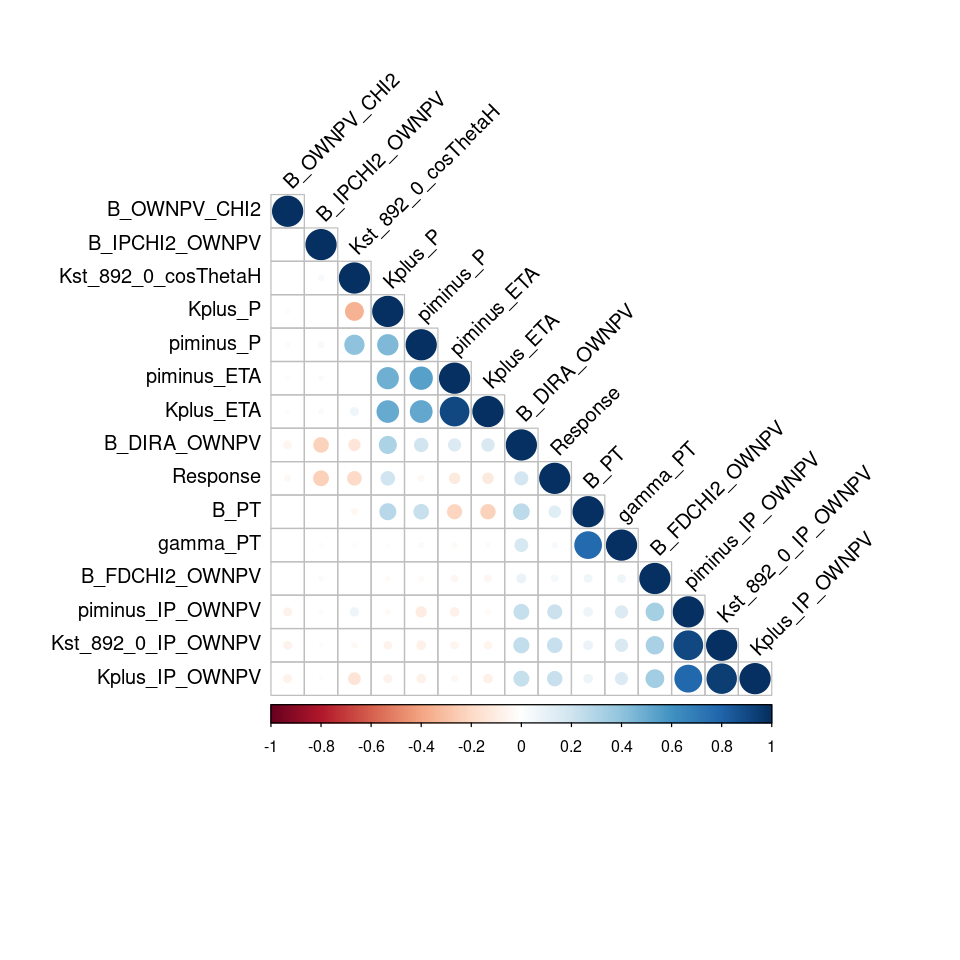

In [18]:
options(repr.plot.width=8,repr.plot.height=8)
corrplot(cor(x.corr), type="lower", order="hclust", tl.col="black", tl.srt=45)

Looks like we have remarkable positive correlation in the pairs **piminus_ETA/Kplus_ETA**, **B_PT/gamma_PT** and the triplet **piminus_IP_OWNPV/Kst_892_0_IP_OWNPV/Kplus_IP_OWNPV**, and negative correlation in the pairs **Kplus_P/Kst_892_0_cosThetaH**, **Kplus_IP_OWNPV/Kst_892_0_cosThetaH**, **B_DIRA_OWNPV/Kst_892_0_cosThetaH**, **B_DIRA_OWNPV/B_IPCHI2_OWNPV**, **B_PT/piminus_ETA** and **B_PT/Kplus_ETA**.

Regarding the response, is has strong negative correlation with **Kst_892_0_cosThetaH** and with **B_IPCHI2_OWNPV**.

The correlations between predictors that do not come from their contribution to determining the signal should in principle be picked out by the shrinkage prior, whose purpose is to cancel them by giving them vanishing coefficients.

## 2. Vanilla logistic regression with STAN

### 2.1. Modelling

We have decided to include this case for reference, so that we can better gauge the later contribution of the horseshoe.
As in Week 12's *GLM.01.Logistic.Challenger.ipynb*, we have centered Gaussian priors for the logistic coefficients $\beta_i$, all with $\sigma = 10$, thus precision $\tau = 0.01$ (the same we use in the horseshoe case for $\beta_0$, for the sake of comparison). The likelihood of the logistic regression is, as seen in the mentioned notebook, a Bernoulli distribution with probability $p_i$ given by the logistic function. More graphically:

$$
    \begin{array}{lclcll}
        y_{i}           &\sim    &Bern(p_i),&&&1\leq i\leq n,\\[0.2cm]
         p_i &=      &\operatorname{Logistic}(\eta_i) =\dfrac{\exp(\eta_i)}{1+\exp(\eta_i)},&&&1\leq i\leq n,\\[0.2cm]
        \eta_{i}         &=     &\beta_{0}+x_{i\,\cdot\,}\cdot \beta,\mskip45mu  &&&1\leq i\leq n,\\[0.2cm]
        \beta_{j}        &\sim   &\normaldist(0,1.0E01), &&0\leq j\leq p,\\[0.2cm]
    \end{array}
$$


Define the STAN model (very similar to what we did with the Challenger data):

In [18]:
model.string<-"
data {
  int<lower=0> N;  
  int<lower=0> p;
  int<lower=0,upper=1> y[N];
  matrix[N,p] X;
}
parameters {
  vector[p] beta;
}

model {
  for (n in 1:N)
     y[n]~ bernoulli_logit( X[n,] * beta );
}"

In [20]:
start.time <- Sys.time()

sample.01 <- stan(model_code = model.string, data = data.01, iter = 20000,
             chains = 1, verbose = FALSE, seed=101, warmup=5000)

end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken


SAMPLING FOR MODEL '5ac535c69ad0c5d6f40a50e6be0c8087' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.00091 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 9.1 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:     1 / 20000 [  0%]  (Warmup)
Chain 1: Iteration:  2000 / 20000 [ 10%]  (Warmup)
Chain 1: Iteration:  4000 / 20000 [ 20%]  (Warmup)
Chain 1: Iteration:  5001 / 20000 [ 25%]  (Sampling)
Chain 1: Iteration:  7000 / 20000 [ 35%]  (Sampling)
Chain 1: Iteration:  9000 / 20000 [ 45%]  (Sampling)
Chain 1: Iteration: 11000 / 20000 [ 55%]  (Sampling)
Chain 1: Iteration: 13000 / 20000 [ 65%]  (Sampling)
Chain 1: Iteration: 15000 / 20000 [ 75%]  (Sampling)
Chain 1: Iteration: 17000 / 20000 [ 85%]  (Sampling)
Chain 1: Iteration: 19000 / 20000 [ 95%]  (Sampling)
Chain 1: Iteration: 20000 / 20000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 88.2062 seconds (Warm-up)
Chain 1:                

Time difference of 8.181272 mins

In [21]:
start.time <- Sys.time()

sample.02 <- stan(model_code = model.string, data = data.02, iter = 20000,
             chains = 1, verbose = FALSE, seed=101, warmup=5000)

end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken


SAMPLING FOR MODEL '5ac535c69ad0c5d6f40a50e6be0c8087' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000492 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 4.92 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:     1 / 20000 [  0%]  (Warmup)
Chain 1: Iteration:  2000 / 20000 [ 10%]  (Warmup)
Chain 1: Iteration:  4000 / 20000 [ 20%]  (Warmup)
Chain 1: Iteration:  5001 / 20000 [ 25%]  (Sampling)
Chain 1: Iteration:  7000 / 20000 [ 35%]  (Sampling)
Chain 1: Iteration:  9000 / 20000 [ 45%]  (Sampling)
Chain 1: Iteration: 11000 / 20000 [ 55%]  (Sampling)
Chain 1: Iteration: 13000 / 20000 [ 65%]  (Sampling)
Chain 1: Iteration: 15000 / 20000 [ 75%]  (Sampling)
Chain 1: Iteration: 17000 / 20000 [ 85%]  (Sampling)
Chain 1: Iteration: 19000 / 20000 [ 95%]  (Sampling)
Chain 1: Iteration: 20000 / 20000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 87.3407 seconds (Warm-up)
Chain 1:              

Time difference of 2.697304 hours

In [22]:
start.time <- Sys.time()

sample.03 <- stan(model_code = model.string, data = data.03, iter = 20000,
             chains = 1, verbose = FALSE, seed=101, warmup=5000)

end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken


SAMPLING FOR MODEL '5ac535c69ad0c5d6f40a50e6be0c8087' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.001089 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 10.89 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:     1 / 20000 [  0%]  (Warmup)
Chain 1: Iteration:  2000 / 20000 [ 10%]  (Warmup)
Chain 1: Iteration:  4000 / 20000 [ 20%]  (Warmup)
Chain 1: Iteration:  5001 / 20000 [ 25%]  (Sampling)
Chain 1: Iteration:  7000 / 20000 [ 35%]  (Sampling)
Chain 1: Iteration:  9000 / 20000 [ 45%]  (Sampling)
Chain 1: Iteration: 11000 / 20000 [ 55%]  (Sampling)
Chain 1: Iteration: 13000 / 20000 [ 65%]  (Sampling)
Chain 1: Iteration: 15000 / 20000 [ 75%]  (Sampling)
Chain 1: Iteration: 17000 / 20000 [ 85%]  (Sampling)
Chain 1: Iteration: 19000 / 20000 [ 95%]  (Sampling)
Chain 1: Iteration: 20000 / 20000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 176.183 seconds (Warm-up)
Chain 1:             

Time difference of 19.981 mins

Visualise output:

In [23]:
summary(sample.01)

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
beta[1],-5.483654e-02,0.0003873179,0.05305817,-1.590604e-01,-9.056074e-02,-5.497076e-02,-1.884710e-02,4.803373e-02,18765.903,0.9999487
beta[2],-6.388736e-01,0.0004645234,0.05837775,-7.553772e-01,-6.779504e-01,-6.384902e-01,-5.994469e-01,-5.258170e-01,15793.541,0.9999814
beta[3],-4.578002e-01,0.0013088890,0.17408590,-8.154244e-01,-5.730797e-01,-4.533035e-01,-3.375866e-01,-1.288375e-01,17689.744,1.0000520
beta[4],2.121222e-02,0.0005172783,0.06446402,-1.031440e-01,-2.276923e-02,2.090037e-02,6.507028e-02,1.485433e-01,15530.533,0.9999778
beta[5],-7.008528e-01,0.0021982779,0.19222820,-1.078889e+00,-8.301838e-01,-7.010495e-01,-5.707214e-01,-3.268853e-01,7646.611,0.9999584
beta[6],1.591059e-01,0.0045066417,0.41259269,-6.382790e-01,-1.224167e-01,1.527218e-01,4.336064e-01,9.896784e-01,8381.794,0.9999363
beta[7],-3.598267e-01,0.0010146858,0.10081377,-5.600617e-01,-4.269249e-01,-3.588611e-01,-2.916233e-01,-1.621938e-01,9871.349,0.9999967
beta[8],1.728472e-01,0.0030809406,0.28800269,-3.977149e-01,-2.273994e-02,1.757157e-01,3.696322e-01,7.339324e-01,8738.290,0.9999334
beta[9],1.101157e+00,0.0014242014,0.13648859,8.357657e-01,1.008488e+00,1.102157e+00,1.192292e+00,1.373932e+00,9184.380,0.9999338
beta[10],3.579732e-01,0.0021599454,0.21052597,-5.529358e-02,2.156643e-01,3.609333e-01,5.017867e-01,7.604750e-01,9500.049,0.9999453


In [24]:
#summary(sample.02)

In [25]:
#summary(sample.03)

'pars' not specified. Showing first 10 parameters by default.

ci_level: 0.8 (80% intervals)

outer_level: 0.95 (95% intervals)



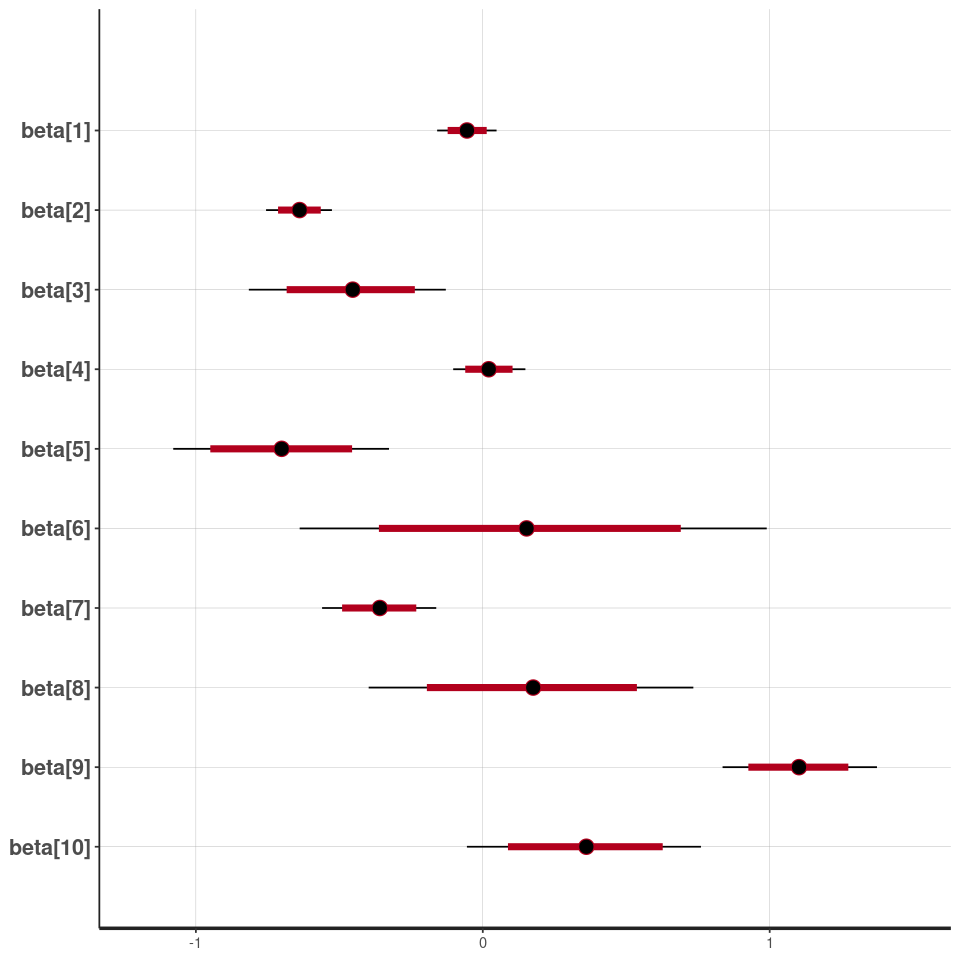

In [26]:
plot(sample.01)

'pars' not specified. Showing first 10 parameters by default.

ci_level: 0.8 (80% intervals)

outer_level: 0.95 (95% intervals)



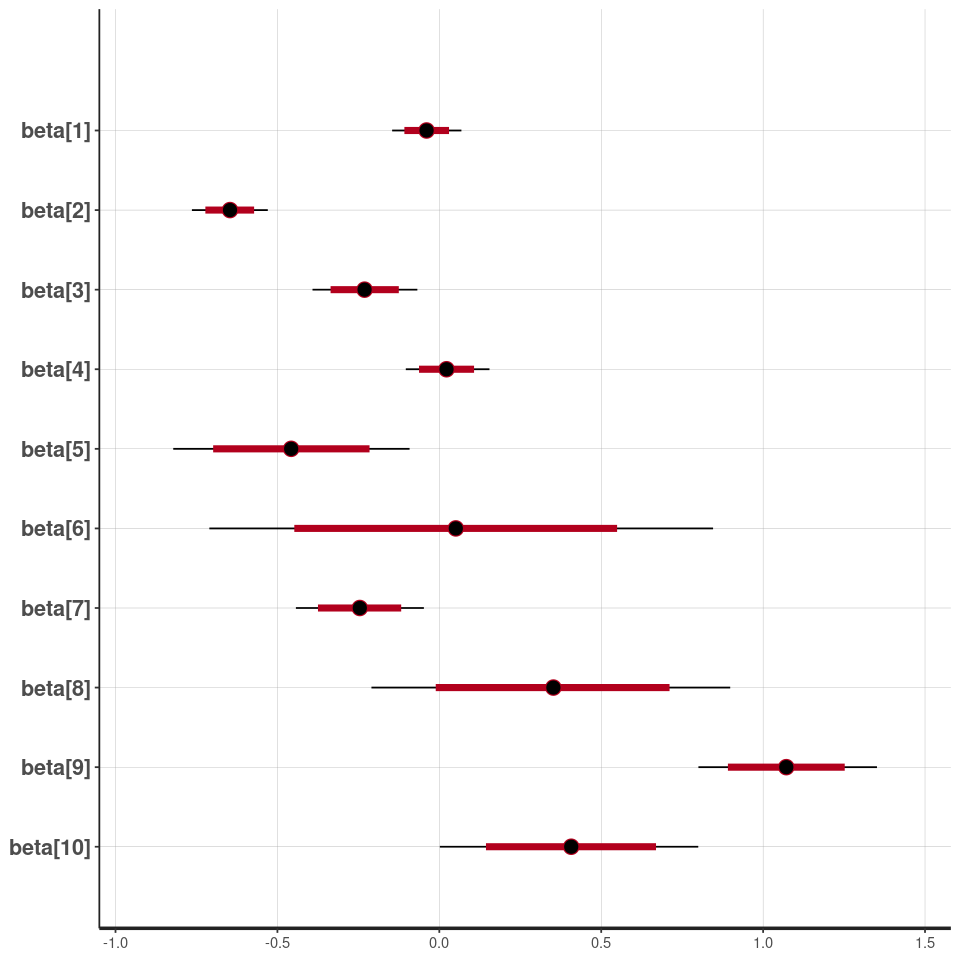

In [27]:
plot(sample.02)

'pars' not specified. Showing first 10 parameters by default.

ci_level: 0.8 (80% intervals)

outer_level: 0.95 (95% intervals)



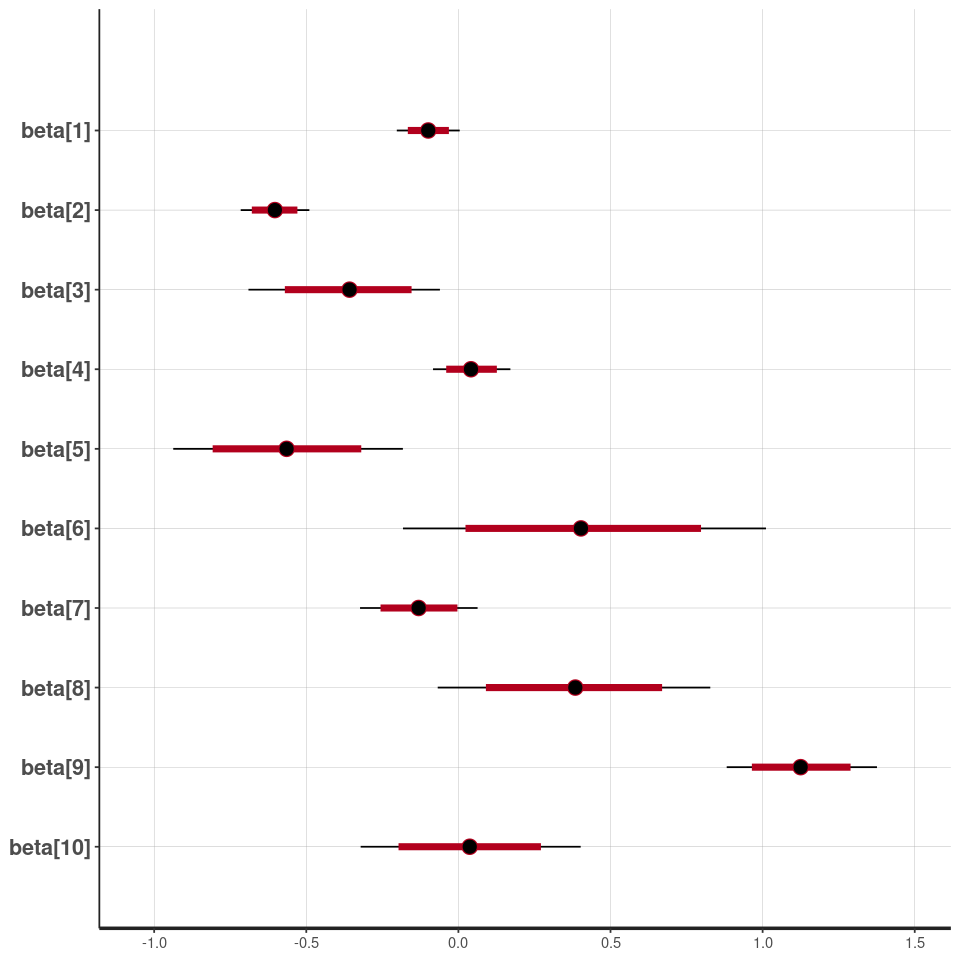

In [28]:
plot(sample.03)

The overall noisy traceplots show that posteriors are correctly sampled, although they are a bit more spread than we would like: we will see how the horseshoe contributes to shrinking them.

To check for consistency among initial subsamples, we look at the mean posterior values of the logistic parameters ($\beta_0$ and $\beta$) for each of them. As several times before, we define a function to do it:

In [29]:
logistic.params<-function(sample){
    #retrieve expected values of logistic regression params (the method in 
    # week12/GLM.01.Logistic.Challenger.ipynb does not work here because the 
    #JAGS object is different)
    stats<-summary(sample)$statistics
    a<-stats[19,1]
    b<-c()
    for (i in 5:18){
        b[i-4]<-stats[i,1]
        }
   return(list("b0"=a, "b"=b))
}

In [32]:
print('Coefficients from sample.01:')
print(colMeans(as.matrix(sample.01))[1:15])
cat('\n')
print('Coefficients from sample.02:')
print(colMeans(as.matrix(sample.02))[1:15])
cat('\n')
print('Coefficients from sample.03:')
print(colMeans(as.matrix(sample.03))[1:15])

[1] "Coefficients from sample.01:"
      beta[1]       beta[2]       beta[3]       beta[4]       beta[5] 
-5.483654e-02 -6.388736e-01 -4.578002e-01  2.121222e-02 -7.008528e-01 
      beta[6]       beta[7]       beta[8]       beta[9]      beta[10] 
 1.591059e-01 -3.598267e-01  1.728472e-01  1.101157e+00  3.579732e-01 
     beta[11]      beta[12]      beta[13]      beta[14]          lp__ 
 5.110132e-01  5.081189e-01 -5.726908e-01 -6.878818e-01 -1.112054e+03 

[1] "Coefficients from sample.02:"
      beta[1]       beta[2]       beta[3]       beta[4]       beta[5] 
-3.932624e-02 -6.469136e-01 -2.305242e-01  2.249122e-02 -4.564325e-01 
      beta[6]       beta[7]       beta[8]       beta[9]      beta[10] 
 5.506246e-02 -2.463772e-01  3.479474e-01  1.071226e+00  4.060750e-01 
     beta[11]      beta[12]      beta[13]      beta[14]          lp__ 
 1.744630e-01  3.994924e-01 -2.696049e-01 -6.641111e-01 -1.106718e+03 

[1] "Coefficients from sample.03:"
      beta[1]       beta[2]       beta[3]

In [31]:
colnames(x0.01)

[1] "B_OWNPV_CHI2"        "B_IPCHI2_OWNPV"      "B_FDCHI2_OWNPV"     
 [4] "B_DIRA_OWNPV"        "B_PT"                "Kst_892_0_IP_OWNPV" 
 [7] "Kst_892_0_cosThetaH" "Kplus_IP_OWNPV"      "Kplus_P"            
[10] "piminus_IP_OWNPV"    "piminus_P"           "gamma_PT"           
[13] "piminus_ETA"         "Kplus_ETA"

Although there is some variability, the posterior means are consistent across subsamples, which contributes to validating their size (note that taking a greater subsample size would yield an unreasonable execution time for the notebook). 

It is worth noting $|\beta_{4}|$ (coefficient for **B_DIRA_OWNPV**) is $<0.05$ for all three original subsamples, meaning that it does not contribute much to the decision boundary. This confirms our intuition when exploring the data, where we already mentioned it is uninformative. The intercept $\beta_0$ is also suppressed.

### 2.2. Evaluation

To evaluate the model, we consider the train and test deviance, AIC and BIC. Since in this case we are applying Bayesian inference to a classification problem, we also compute the area under de ROC curve, which has the advantage over the latter that it is bounded and has absolute meaning (whereas deviation, AIC and BIC increase indefinitely with the size of the dataset used). Having established at the beginning of the notebook that we are mostly interested in true positives, we also look at recall (a.k.a. sensitivity, the fraction of total positives predicted as such): although we will show the other metrics for completeness, we will concentrate on AUC and recall, the latter computed for the optimal operating point of the ROC curve.

Note that for the test we use all samples not included in the corresponding 2000 train subsample, so **we test with about 210 000 samples** each time. We do this to put to use all available information, and we can afford to do so at test because we are just evaluating the logistic function (what took so long at train was the MCMC sampling).

Since, once again, we wil do this several times, we define a function to compute and print all relevant evaluation metrics. In the case of the train phase, we also print the deviance, AIC and BIC computed by STAN, for reference.

In [35]:
evaluate<-function(sample, x, y, phase, threshold=NULL){
    n<-dim(x)[1]    
    n.pars<-dim(x)[2]
    b<-colMeans(as.matrix(sample))[1:14]
    #probabilities
    eta.bar<-as.numeric(as.matrix(x) %*% b)
    p.bar<-1/(1+exp(-eta.bar))
    #log-likelihood
    logL.hat<-sum(y * log(p.bar) + (1 - y) * log(1 - p.bar))
    #AUC
    roc_obj <- roc(y, p.bar)
    AUC.hat<-auc(roc_obj)
    cat("\n", phase,"AUC:", round(AUC.hat,4)) 
    #deviance
    D.hat<- -2*logL.hat
    cat("\n", phase,"Deviance:", round(D.hat,4))  
    #AIC
    AIC.hat<-D.hat+2*n.pars
    cat("\n", phase,"AIC:", round(AIC.hat,4))  
    #BIC
    BIC.hat<-D.hat+log(n)*n.pars
    cat("\n", phase,"BIC:", round(BIC.hat,4))  
    #if training phase, print JAGS quantities as well for comparison
    if (phase=="train"){ 
        #compute threshold and recall/sensitivity for best operating point
        #in ROC curve
        rc <- ROC(test=p.bar, stat = as.logical(y), plot="ROC", main="Train ROC curve") 
        # optimal combination
        opt <- which.max(rowSums(rc$res[, c("sens", "spec")]))
        # optimal cut-off point and corresponding recall
        threshold = as.numeric(names(opt))
        recall<-rc$res$sens[opt]
        cat("\n", phase, "recall/sensitivity", round(recall, 4))
        return(threshold)
        } else{
        check<-y+p.bar
        true.p<-0
        total.p<-sum(y)
        for (num in check){
            if (num >= (1+threshold)){
            true.p<-true.p+1    
            }
        }
        recall<-true.p/total.p
        cat("\n", phase, "recall/sensitivity", round(recall, 4))
            
        }
    
    }

Having our function, we call it for the result obtained for each original subsample:

Setting levels: control = 0, case = 1

Setting direction: controls < cases




 train AUC: 0.7921
 train Deviance: 2210.078
 train AIC: 2238.078
 train BIC: 2316.491
 train recall/sensitivity 0.799

Setting levels: control = 0, case = 1

Setting direction: controls < cases




 test AUC: 0.7896
 test Deviance: 249420.4
 test AIC: 249448.4
 test BIC: 249592
 test recall/sensitivity 0.8571

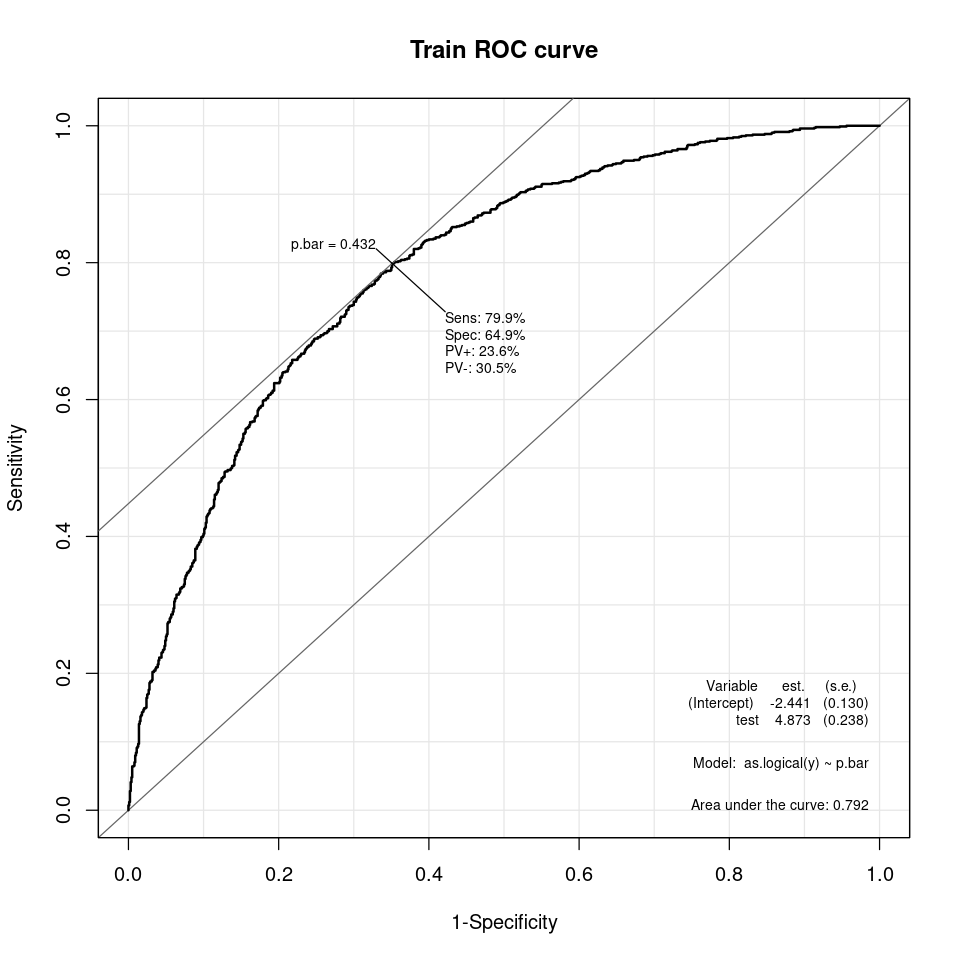

In [36]:
#evaluate train
thr<-evaluate(sample.01, x0.01, y.01, phase="train")
# evaluate test
xt<-model.matrix(Response~.,test.01)[,-1] #[,-1] to remove intercept intrduced by model.matrix
xt<-standardise(xt)
yt<-test.01$Response
evaluate(sample.01, xt, yt, phase="test", threshold = thr)

Setting levels: control = 0, case = 1

Setting direction: controls < cases




 train AUC: 0.7925
 train Deviance: 2199.329
 train AIC: 2227.329
 train BIC: 2305.742
 train recall/sensitivity 0.748

Setting levels: control = 0, case = 1

Setting direction: controls < cases




 test AUC: 0.7894
 test Deviance: 249425.9
 test AIC: 249453.9
 test BIC: 249597.5
 test recall/sensitivity 0.8022

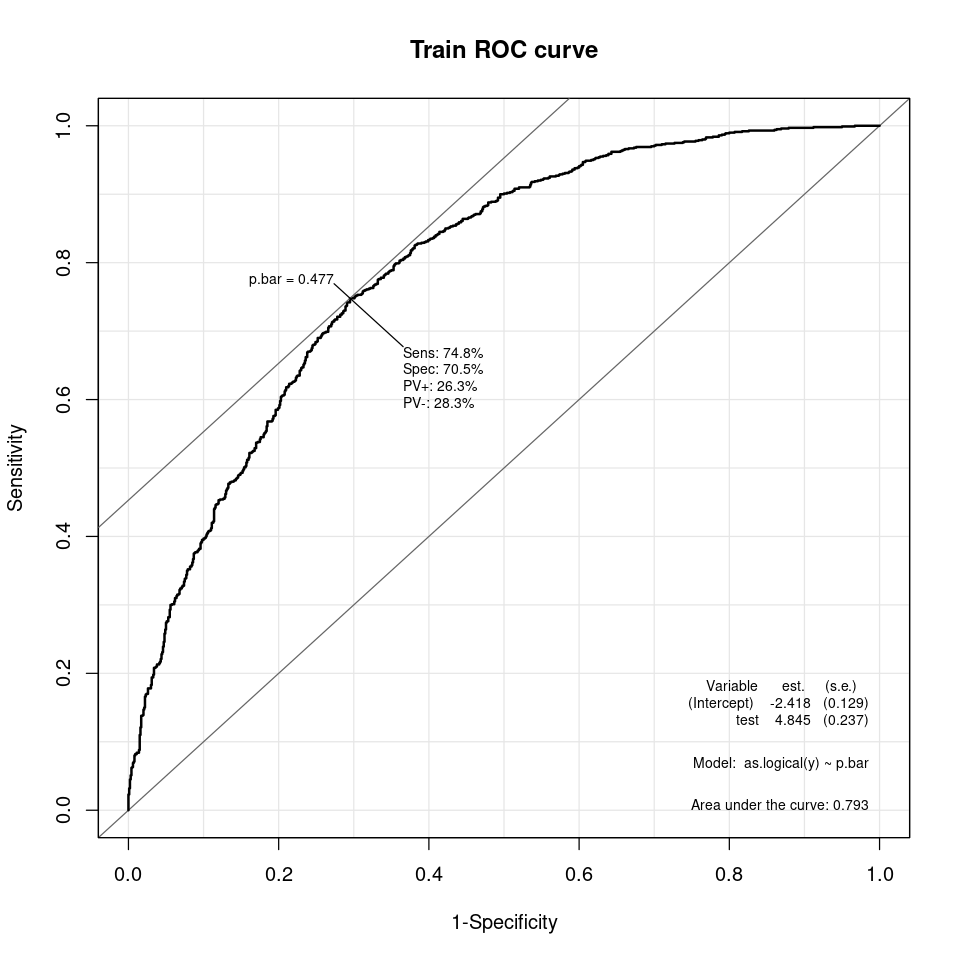

In [37]:
thr<-evaluate(sample.02, x0.02, y.02, phase="train")

xt<-model.matrix(Response~.,test.02)[,-1] #[,-1] to remove intercept intrduced by model.matrix
xt<-standardise(xt)
yt<-test.02$Response
evaluate(sample.02, xt, yt, phase="test", threshold = thr)

Setting levels: control = 0, case = 1

Setting direction: controls < cases




 train AUC: 0.7928
 train Deviance: 2197.888
 train AIC: 2225.888
 train BIC: 2304.3
 train recall/sensitivity 0.702

Setting levels: control = 0, case = 1

Setting direction: controls < cases




 test AUC: 0.7897
 test Deviance: 249248.5
 test AIC: 249276.5
 test BIC: 249420.1
 test recall/sensitivity 0.7734

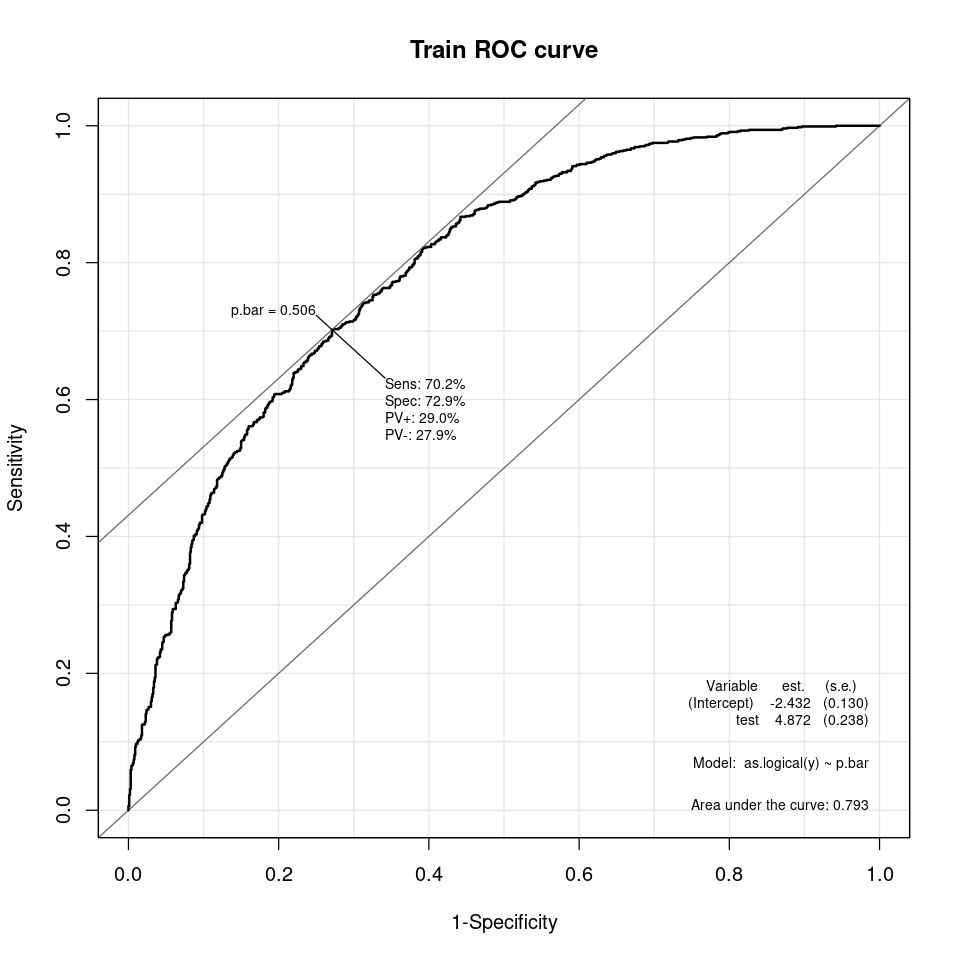

In [38]:
thr<-evaluate(sample.03, x0.03, y.03, phase="train")

xt<-model.matrix(Response~.,test.03)[,-1] #[,-1] to remove intercept intrduced by model.matrix
xt<-standardise(xt)
yt<-test.03$Response
evaluate(sample.03, xt, yt, phase="test", threshold = thr)

We get similar (and only moderately encouraging) test AUCs across subsamples (0.79), while test recall varies from 0.78 to 0.86. Not bad, if we consider that our train and test sizes (2 000 vs 210 000), although the AUC obtained by the winners of the competition was 0.94 and our own best result was as high as 0.90, both with a neural network. This difference may thus come from the dataset's not being linearly separable, added to the fact that the better results used many more samples for training/learning and many less for testing/"critisising" the model. We will see if we are able to improve our results by considering a more sophisticated undersampling strategy and the spike-slab prior.

The similarity across subsamples contributes to validating their size, with a caveat on the recall.

## 3. Introducing the Horseshoe shrinkage prior

We have seen in class that Lasso (or L1) regularisation is better at predictor selection than the Ridge (L2) due to the square form of the 1-norm vs the circle that is the 2-norm. We have also seen that the horseshoe performs even better than Lasso at shrinking posteriors, something supported by (Bhadra et al., 2017) (https://arxiv.org/abs/1706.10179). The authors furthermore argue that the heavy tails and spike at 0 of the horseshoe prior make it adaptive to sparse signals as well (although this is no longer our case, since we undersampled a balanced subset of the data).

From the above, it seems rather natural to want to try such a shrinkage prior, and we do so in the following cells. As we have seen the Horseshoe shrinkage prior does not help much achieve better results, thus in STAN we only implement it for one sample (since for solving convergence issues we need to train models that need a lot of time, and it does not help much) for the sake of completeness.

### 3.1. Modelling

As seen in class, the latent variable formulation of the Horsehoe is

$$
    \begin{aligned} 
    (\beta_i|\lambda_i, \tau) \sim N(0, \lambda_i^2\tau^2)\\[0.2cm]
     \lambda_i \sim \halfcauchydist(0, 1)\\[0.2cm]
     \tau \sim \halfcauchydist(0, 1)\\[0.2cm]
    \end{aligned}
$$

where $\halfcauchydist(0, 1)$ is the half-Cauchy distribution. 

$\beta_{0}$ is the intercept, $\beta=(\beta_{1},\dots,\beta_{p})$ is the vector of regression coefficients,    
$\tau_{\beta}=1/\sigma_{\beta}^{2}$ is the common precision parameter for the regression coefficients.

$$
    \begin{array}{lclcll}
        y_{i}           &\sim    &Bern(p_i),&&&1\leq i\leq n,\\[0.2cm]
         p_i &=      &\operatorname{Logistic}(\eta_i) =\dfrac{\exp(\eta_i)}{1+\exp(\eta_i)},&&&1\leq i\leq n,\\[0.2cm]
        \eta_{i}         &=     &\beta_{0}+x_{i\,\cdot\,}\cdot \beta,\mskip45mu  &&&1\leq i\leq n,\\[0.2cm]
        \beta_{0}        &\sim   &\normaldist(0,1.0E01),\\[0.2cm]
        \beta_{j}        &\sim   &\normaldist(0,\psi_{\beta,j}), &&1\leq j\leq p,\\[0.2cm]
        \psi_{\beta,j}   &=      &1/\sigma_{\beta,j}^{2},        &&1\leq j\leq p,  &\text{(Precision parameter for } \beta_{j})\\[0.2cm]              
        \sigma_{\beta,j} &=      &\lambda_{j}\cdot\tau,          &&1\leq j\leq p,\\[0.2cm]
        \lambda_{j}      &\sim   &\halfcauchydist(0, 1),         &&1\leq j\leq p,\\[0.2cm]
        \tau             &\sim   &\halfcauchydist(0, 1).
    \end{array}
$$

With the above information, we define the STAN model:

In [19]:
model.string<-"
data {
  int<lower=0> N;  
  int<lower=0> p;
  int<lower=0,upper=1> y[N];
  matrix[N,p] X;
}
parameters {
  vector[p] beta;
  vector<lower=0>[p] lambda;
  real<lower=0> tau;
}

model {
  lambda ~ cauchy(0, 1);
  tau ~ cauchy(0, 1);
  for (i in 1:p)
    beta[i] ~ normal(0, 1/(lambda[i] * tau)^2);
  for (n in 1:N)
     y[n]~ bernoulli_logit( X[n,] * beta );
}"

Define parameters and data (this one for each initial subsample), and the corresponding models:

In [20]:
n1<-dim(x0.01)[1]
n2<-dim(x0.02)[1]
n3<-dim(x0.03)[1]

p<-dim(x0.01)[2]

data.01 <-list(X = x0.01, y=y.01, N=length(y.01), p<-p)
data.02 <-list(X = x0.02, y=y.02, N=length(y.02), p<-p)
data.03 <-list(X = x0.03, y=y.03, N=length(y.03), p<-p)

Run one chain per model with 20 000 iterations and a burnout of the 5000 (see summary(sample.01)) initial samples (those that will be discarded to assure randomness of MCMC sampling). Note that this takes around 35 min each time:

In [24]:
start.time <- Sys.time()

sample.01 <- stan(model_code = model.string, data = data.01, iter = 10000,
             chains = 1, verbose = FALSE, seed=101, warmup=500, control = list(adapt_delta = 0.99))

end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken


SAMPLING FOR MODEL '562b271846d5ba2887af73a1ffa2dab2' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000932 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 9.32 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)
Chain 1: Iteration:  501 / 10000 [  5%]  (Sampling)
Chain 1: Iteration: 1500 / 10000 [ 15%]  (Sampling)
Chain 1: Iteration: 2500 / 10000 [ 25%]  (Sampling)
Chain 1: Iteration: 3500 / 10000 [ 35%]  (Sampling)
Chain 1: Iteration: 4500 / 10000 [ 45%]  (Sampling)
Chain 1: Iteration: 5500 / 10000 [ 55%]  (Sampling)
Chain 1: Iteration: 6500 / 10000 [ 65%]  (Sampling)
Chain 1: Iteration: 7500 / 10000 [ 75%]  (Sampling)
Chain 1: Iteration: 8500 / 10000 [ 85%]  (Sampling)
Chain 1: Iteration: 9500 / 10000 [ 95%]  (Sampling)
Chain 1: Iteration: 10000 / 10000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 275.259 seconds (Warm-up)
Chain 1:                5829.

Warning message:
“There were 486 divergent transitions after warmup. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“There were 8702 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#bulk-ess”
Warning message:
“Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#tail-ess”


Time difference of 1.793526 hours

Visualise output:

In [25]:
summary(sample.01)

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
beta[1],-2.952317e-02,0.0006583539,0.04291003,-1.322277e-01,-5.495173e-02,-1.660548e-02,1.235021e-04,3.241912e-02,4248.14054,0.9999998
beta[2],-6.359086e-01,0.0007993636,0.05669195,-7.465382e-01,-6.745531e-01,-6.354206e-01,-5.971831e-01,-5.254162e-01,5029.83867,0.9999098
beta[3],-3.651036e-01,0.0050900363,0.19389858,-7.482668e-01,-4.955917e-01,-3.666029e-01,-2.339131e-01,-1.289460e-03,1451.13393,1.0000624
beta[4],4.875714e-03,0.0006943291,0.03917620,-7.704120e-02,-1.008392e-02,4.148051e-04,1.851145e-02,9.968465e-02,3183.56555,0.9999246
beta[5],-2.489171e-01,0.0639174773,0.25866266,-8.953358e-01,-4.214173e-01,-1.697297e-01,-2.037428e-02,2.729175e-02,16.37677,1.0116384
beta[6],2.947697e-01,0.0109904894,0.27469485,-1.214533e-01,2.319895e-02,2.857016e-01,5.269613e-01,7.888292e-01,624.69347,1.0088803
beta[7],-2.745893e-01,0.0061183621,0.12857920,-5.256964e-01,-3.624099e-01,-2.763190e-01,-1.886885e-01,-9.660601e-03,441.64274,1.0108917
beta[8],1.339920e-01,0.0082988115,0.18977014,-1.507633e-01,-3.162789e-04,6.747171e-02,2.637776e-01,5.605829e-01,522.90640,1.0213997
beta[9],9.567002e-01,0.0205860944,0.15536203,6.598226e-01,8.537304e-01,9.522433e-01,1.056795e+00,1.276544e+00,56.95631,0.9999164
beta[10],2.199432e-01,0.0080542312,0.19858719,-5.169434e-02,2.777309e-02,2.018064e-01,3.684287e-01,6.275261e-01,607.93099,0.9999378


'pars' not specified. Showing first 10 parameters by default.

ci_level: 0.8 (80% intervals)

outer_level: 0.95 (95% intervals)



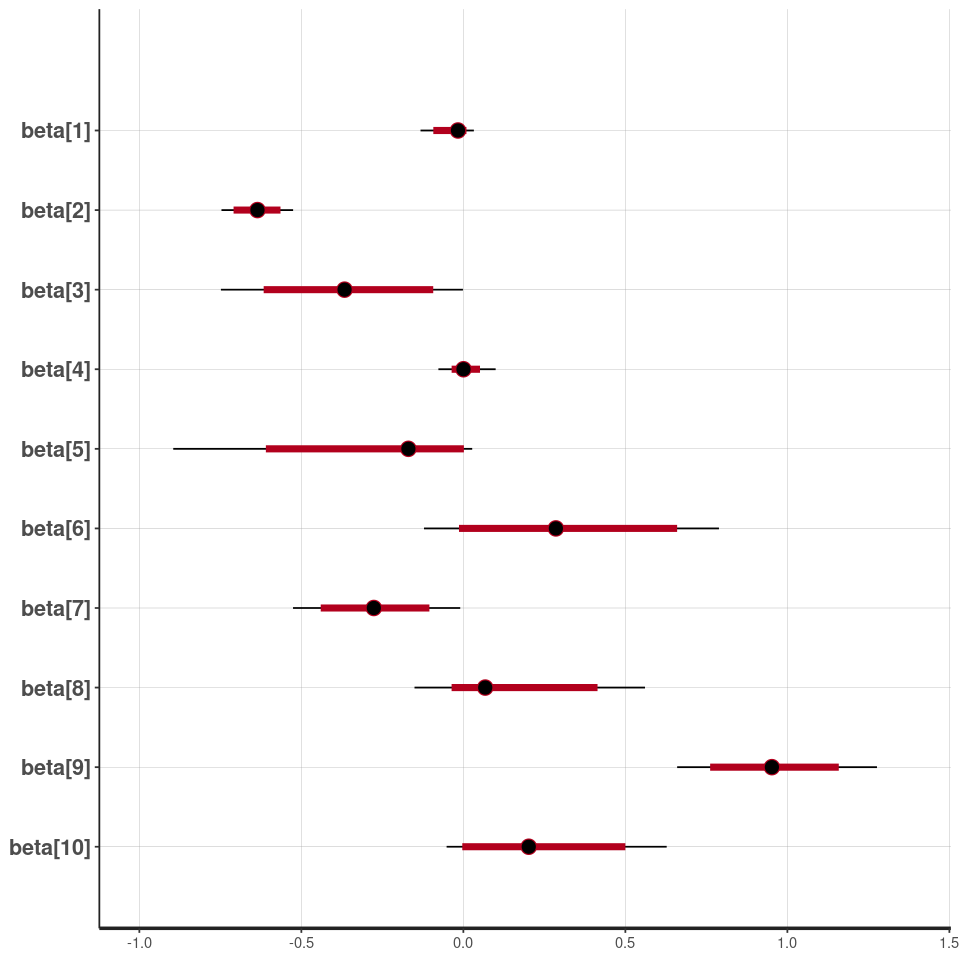

In [32]:
plot(sample.01)

Again, the traceplots of the logistic parameters look noisy enough, but that is not the case for all their sigmas: unfortunately, we could not improve this in a reasonable computation time. Some of the $\beta$ posteriors look sharper than for the vanilla implementation, but the effect is far from ubiquitous and there are even some that look flatter (somewhat disappointingly, considering the supposed interest of the horseshoe for shrinking).

To check for consistency among initial subsamples, we look at the mean posterior values of the logistic parameters ($\beta_0$ and $\beta$) for each of them. We use the function defined for the vanilla version:

In [31]:
logistic.params(sample.01)
# logistic.params(sample.02)
# logistic.params(sample.03)

ERROR: Error in logistic.params(sample.01): could not find function "logistic.params"


In [27]:
colnames(x0.01)

[1] "B_OWNPV_CHI2"        "B_IPCHI2_OWNPV"      "B_FDCHI2_OWNPV"     
 [4] "B_DIRA_OWNPV"        "B_PT"                "Kst_892_0_IP_OWNPV" 
 [7] "Kst_892_0_cosThetaH" "Kplus_IP_OWNPV"      "Kplus_P"            
[10] "piminus_IP_OWNPV"    "piminus_P"           "gamma_PT"           
[13] "piminus_ETA"         "Kplus_ETA"

Again, although there is some variability (perhaps more than in the vanilla case), the posterior means present overall consistence. Note that $\beta_4$ (**B_DIRA_OWNPV**) is more suppressed than in the vanilla case, while the intercept is similarly supressed. Regarding predictors specifically supressed by the horseshoe, it seems we have both $\beta_1$ (**B_OWNPV_CHI2**) and $\beta_{11}$ (**piminus_P**). It is however somewhat puzzling that the predictors filtered out by the horseshoe are not among the ones showing colinearity at preprocessing.

### 3.2. Evaluation

We use the evaluation function defined for the vanilla logistic regression to get train and test deviation, AIC, BIC, AUC and recall:

In [29]:
evaluate<-function(sample, x, y, phase, threshold=NULL){
    n<-dim(x)[1]    
    n.pars<-dim(x)[2]
    b<-colMeans(as.matrix(sample))[1:14]
    #probabilities
    eta.bar<-as.numeric(as.matrix(x) %*% b)
    p.bar<-1/(1+exp(-eta.bar))
    #log-likelihood
    logL.hat<-sum(y * log(p.bar) + (1 - y) * log(1 - p.bar))
    #AUC
    roc_obj <- roc(y, p.bar)
    AUC.hat<-auc(roc_obj)
    cat("\n", phase,"AUC:", round(AUC.hat,4)) 
    #deviance
    D.hat<- -2*logL.hat
    cat("\n", phase,"Deviance:", round(D.hat,4))  
    #AIC
    AIC.hat<-D.hat+2*n.pars
    cat("\n", phase,"AIC:", round(AIC.hat,4))  
    #BIC
    BIC.hat<-D.hat+log(n)*n.pars
    cat("\n", phase,"BIC:", round(BIC.hat,4))  
    #if training phase, print JAGS quantities as well for comparison
    if (phase=="train"){ 
        #compute threshold and recall/sensitivity for best operating point
        #in ROC curve
        rc <- ROC(test=p.bar, stat = as.logical(y), plot="ROC", main="Train ROC curve") 
        # optimal combination
        opt <- which.max(rowSums(rc$res[, c("sens", "spec")]))
        # optimal cut-off point and corresponding recall
        threshold = as.numeric(names(opt))
        recall<-rc$res$sens[opt]
        cat("\n", phase, "recall/sensitivity", round(recall, 4))
        return(threshold)
        } else{
        check<-y+p.bar
        true.p<-0
        total.p<-sum(y)
        for (num in check){
            if (num >= (1+threshold)){
            true.p<-true.p+1    
            }
        }
        recall<-true.p/total.p
        cat("\n", phase, "recall/sensitivity", round(recall, 4))
            
        }
    
    }

Setting levels: control = 0, case = 1

Setting direction: controls < cases




 train AUC: 0.7901
 train Deviance: 2217.955
 train AIC: 2245.955
 train BIC: 2324.368
 train recall/sensitivity 0.716

Setting levels: control = 0, case = 1

Setting direction: controls < cases




 test AUC: 0.7896
 test Deviance: 248331.4
 test AIC: 248359.4
 test BIC: 248503
 test recall/sensitivity 0.7698

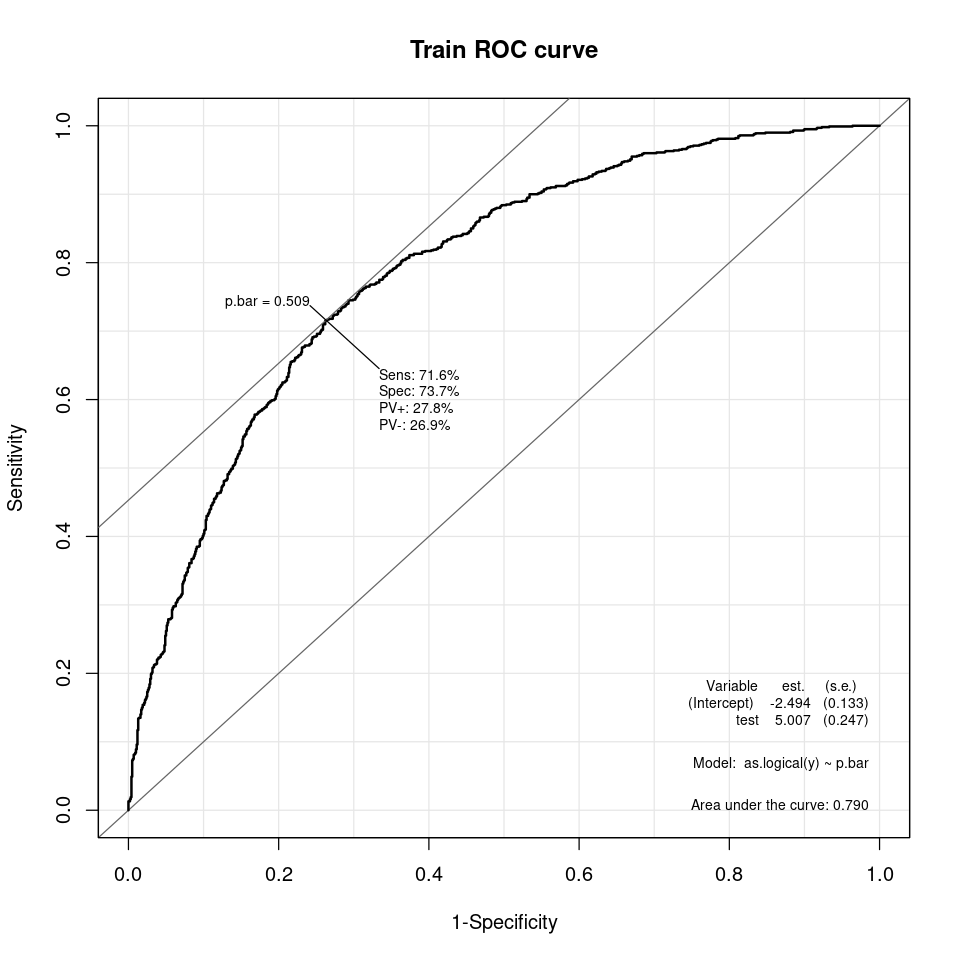

In [30]:
thr<-evaluate(sample.01, x0.01, y.01, phase="train")

xt<-model.matrix(Response~.,test.01)[,-1] #[,-1] to remove intercept intrduced by model.matrix
xt<-standardise(xt)
yt<-test.01$Response
evaluate(sample.01, xt, yt, phase="test", threshold = thr)